# DATA Gathering

In [1]:
import gzip
import simplejson

def parse(filename):
    f = gzip.open(filename, 'rt', encoding='utf-8')
    entry = {}
    for l in f:
        l = l.strip()
        colonPos = l.find(':')
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        eName = l[:colonPos]
        rest = l[colonPos+2:]
        entry[eName] = rest
    yield entry

output_filename = "output.json"

with open(output_filename, 'w') as output_file:
    for e in parse("Clothing_&_Accessories.txt.gz"):
        json_data = simplejson.dumps(e)
        output_file.write(json_data + '\n')


In [2]:
import json

# Read the input file line by line and append each JSON object to a list
input_list = []
with open('./output.json') as f:
    for line in f:
        input_list.append(json.loads(line))

# Write the list as a JSON array to a new file
with open('output_file.json', 'w') as f:
    json.dump(input_list, f)

In [6]:
import pandas as pd

dataframe = pd.read_json('./output_file.json')
dataframe.to_csv('Reviews.csv', sep=',', index=False)

# PROJECT IMPORTS

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("Reviews.csv")

In [4]:
print(df.columns)
print(df.shape)

Index(['product/productId', 'product/title', 'product/price', 'review/userId',
       'review/profileName', 'review/helpfulness', 'review/score',
       'review/time', 'review/summary', 'review/text'],
      dtype='object')
(581934, 10)


### Product based CF

In [5]:
numeric_columns = ["review/score", "review/time"]

count = df.groupby("product/productId", as_index=False).count()
mean = df.groupby("product/productId", as_index=False)[numeric_columns].mean()

dfMerged = pd.merge(df, count, how='right', on=['product/productId'])
dfMerged

,product/productId,product/title_x,product/price_x,review/userId_x,review/profileName_x,review/helpfulness_x,review/score_x,review/time_x,review/summary_x,review/text_x,product/title_y,product/price_y,review/userId_y,review/profileName_y,review/helpfulness_y,review/score_y,review/time_y,review/summary_y,review/text_y
0,0970219660,Smart Packing for Today's Traveler,unknown,A15826QQN8N6NO,Elizabeth Hamilton,0/1,5.0,1.307578e+09,Excellent & Thorough,I am always looking for packing advice to furt...,34,34,34,34,34,34,34,34,34
1,0970219660,Smart Packing for Today's Traveler,unknown,A3W0VN456TVXPZ,"F. Bemiss ""Paula b.""",0/1,4.0,1.193530e+09,helpful info,this is a helpful book i can refer to in a sna...,34,34,34,34,34,34,34,34,34
2,0970219660,Smart Packing for Today's Traveler,unknown,A13WKD1AZDGQE9,iHaveParrrots,2/5,4.0,1.170374e+09,Definitely worth a read,I had the opportunity to skim through this boo...,34,34,34,34,34,34,34,34,34
3,0970219660,Smart Packing for Today's Traveler,unknown,A3EMTWQ32V0W10,J. Carta,0/3,5.0,1.209946e+09,Smart Packing,The service was great. Received quickly and in...,34,34,34,34,34,34,34,34,34
4,0970219660,Smart Packing for Today's Traveler,unknown,A3N6WQF2VO3C4F,"ssipdx ""ssipdx""",57/58,5.0,9.936000e+08,Finally travel instructions that make sense an...,I have been a traveler for 30 years and each t...,34,34,34,34,34,34,34,34,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581928,B000V2RR9O,Amazon.com: Ankh Apparel Black Koi Fish T-Shir...,unknown,A22YYZT7YCVRIF,susan toner,0/0,5.0,1.203379e+09,Happy,I was very pleased to find the Ankh tee's they...,1,1,1,1,1,1,1,1,1
581929,B000VDV64A,"Amazon.com: Nautica Men&#39;s Passcase, Brown,...",unknown,AJNYI51X9C5KE,G. Michael,5/5,3.0,1.179619e+09,Nice but a little thick.,This wallet has a zippered cash section that y...,3,3,3,3,3,3,3,3,3
581930,B000VDV64A,"Amazon.com: Nautica Men&#39;s Passcase, Brown,...",unknown,A2917LH88FC19B,Jose Luis Parra Quebrada,0/0,5.0,1.340064e+09,excelente,"excelente producto, muy buena calidad, y profe...",3,3,3,3,3,3,3,3,3
581931,B000VDV64A,"Amazon.com: Nautica Men&#39;s Passcase, Brown,...",unknown,A1ZQ3PZTCIO1M8,"Aubs ""Aubri""",0/0,5.0,1.316218e+09,Great Wallet,This was an awesome wallet till it went throug...,3,3,3,3,3,3,3,3,3


In [6]:
#rename column
dfMerged["totalReviewers"] = dfMerged["review/userId_y"]
dfMerged["overallScore"] = dfMerged["review/score_x"]
dfMerged["summaryReview"] = dfMerged["review/summary_x"]

dfNew = dfMerged[['product/productId','summaryReview','overallScore',"totalReviewers"]]

Selecting products which have more than 100 reviews

In [7]:
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 100]
dfCount

,product/productId,product/title_x,product/price_x,review/userId_x,review/profileName_x,review/helpfulness_x,review/score_x,review/time_x,review/summary_x,review/text_x,...,review/userId_y,review/profileName_y,review/helpfulness_y,review/score_y,review/time_y,review/summary_y,review/text_y,totalReviewers,overallScore,summaryReview
559318,B000NZW3KC,Amazon.com: The Mountain Three Wolf Moon Short...,unknown,A22KWF56R3EW12,Ralph Davis,0/7,5.0,1.252368e+09,I'm NOT too sexy for THIS shirt!!!!,I'm too sexy for my love too sexy for my loveL...,...,2393,2393,2393,2393,2393,2393,2393,2393,5.0,I'm NOT too sexy for THIS shirt!!!!
557766,B000NZW3KC,Amazon.com: The Mountain Three Wolf Moon Short...,unknown,AZ3GO43X251UB,Gooseberry,1/1,5.0,1.261008e+09,Dark fiber is the secret!!!!!! Gooseberry United,As a Cougar at heart and Husky hater I still c...,...,2393,2393,2393,2393,2393,2393,2393,2393,5.0,Dark fiber is the secret!!!!!! Gooseberry United
557755,B000NZW3KC,Amazon.com: The Mountain Three Wolf Moon Short...,unknown,A1W7IEAM04U2KC,Max,1/1,5.0,1.360109e+09,My life is paradise,Since I have this t-shirt all is beautiful in ...,...,2393,2393,2393,2393,2393,2393,2393,2393,5.0,My life is paradise
557756,B000NZW3KC,Amazon.com: The Mountain Three Wolf Moon Short...,unknown,A64XVTZ6CKDM,M. Trojan,1/1,5.0,1.357690e+09,He Loved it!,It's hard to tell from the picture but it's sl...,...,2393,2393,2393,2393,2393,2393,2393,2393,5.0,He Loved it!
557757,B000NZW3KC,Amazon.com: The Mountain Three Wolf Moon Short...,unknown,A2LG8FNU15T0QF,Kevin,1/1,5.0,1.356998e+09,beautiful stranger,My little sister was absolutely elated when sh...,...,2393,2393,2393,2393,2393,2393,2393,2393,5.0,beautiful stranger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220651,B00024WODK,Amazon.com: Dickies Men&#39;s Flat Front Multi...,unknown,A2T2CSBNG28Q7Y,"A. Malone ""shopsalot""",0/0,5.0,1.357603e+09,great!!,These pants fit my husband perfectly. He was l...,...,100,100,100,100,100,100,100,100,5.0,great!!
220652,B00024WODK,Amazon.com: Dickies Men&#39;s Flat Front Multi...,unknown,A1KNUCG6HEIZV8,kitewheel,0/0,4.0,1.355357e+09,Comfortable to wear,It is hard to become dirty and it has also an ...,...,100,100,100,100,100,100,100,100,4.0,Comfortable to wear
220653,B00024WODK,Amazon.com: Dickies Men&#39;s Flat Front Multi...,unknown,A3W0PLNY7KUMUC,Dennis R. Lodico,0/0,5.0,1.353715e+09,Made to order!,These pants were delivered in a timely manner....,...,100,100,100,100,100,100,100,100,5.0,Made to order!
220654,B00024WODK,Amazon.com: Dickies Men&#39;s Flat Front Multi...,unknown,A11TXBTIHS8ZL7,B. Foster,0/0,5.0,1.353629e+09,"Great, inexpensive, tactical pant substitute.","Out of the bag, these pants fit right and look...",...,100,100,100,100,100,100,100,100,5.0,"Great, inexpensive, tactical pant substitute."


### Grouping all the summary Reviews by product ID

In [8]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

dfProductReview = df.groupby("product/productId", as_index=False)[numeric_columns].mean()
ProductReviewSummary = dfCount.groupby("product/productId")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [9]:
dfProductReview

,product/productId,review/score,review/time
0,0970219660,4.588235,1.162372e+09
1,B00000111D,4.937500,1.105288e+09
2,B00000593F,4.750000,9.302904e+08
3,B00000IRLL,4.250000,9.750240e+08
4,B00000IUYP,4.500000,1.190376e+09
...,...,...,...
66365,B000UVKZ36,5.000000,1.203034e+09
66366,B000V1O4F0,3.800000,1.259747e+09
66367,B000V2RR9O,5.000000,1.203379e+09
66368,B000VDV64A,4.333333,1.278634e+09


### Create dataframe with certain columns

In [10]:
df3 = pd.read_csv("ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="product/productId", how='inner')

In [11]:
df3 = df3[['product/productId','summaryReview','review/score']]

In [12]:
df3

,product/productId,summaryReview,review/score
0,B0000224GL,"['Great bibs- YES they do run small!', 'A++++ ...",4.719008
1,B0000224GM,"['Better than ever', 'Carhartt bibs', 'Quality...",4.719008
2,B00004SR8Z,"['Exactly What It Was Represented to be', 'OK ...",4.470588
3,B00004U1J2,"['Buzz Halloween', 'Basic', 'They were perfect...",3.712230
4,B000074VEG,"['Excellent pants', 'stiff fabric', 'better th...",4.506173
...,...,...,...
1234,B000R2YR78,"['Awesome glasses, nose rubber wears off overt...",4.282443
1235,B000R2YR7S,"['so-so', 'Did not last a year', 'Liked them w...",4.282443
1236,B000R3657W,"['Decent, fog alot', ""Best glasses I've ever o...",4.282443
1237,B000RN2CCE,"['I love my ugly bra!', 'Best bra on the marke...",3.854305


### Text Cleaning - Summary column

In [13]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [14]:
#reset index and drop duplicate rows
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['review/score'], keep='last')
df3 = df3.reset_index()

In [15]:
df3

,index,product/productId,summaryReview,review/score,summaryClean
0,1,B0000224GM,"['Better than ever', 'Carhartt bibs', 'Quality...",4.719008,better than ever carhartt bibs quality outstan...
1,2,B00004SR8Z,"['Exactly What It Was Represented to be', 'OK ...",4.470588,exactly what it was represented to be ok pouch...
2,3,B00004U1J2,"['Buzz Halloween', 'Basic', 'They were perfect...",3.712230,buzz halloween basic they were perfect too cut...
3,6,B000074VEI,"['nice for ths price', 'great', 'Good Work Pan...",4.518987,nice for ths price great good work pants nice ...
4,20,B0000868IV,"['Excellent Support!', 'Bra in not so common s...",4.201389,excellent support bra in not so common size ho...
...,...,...,...,...,...
277,1231,B000QWA2KU,"['Great waist cincher !', 'mokeyshome', 'Very ...",3.967611,great waist cincher mokeyshome very awazing pr...
278,1232,B000QYEY7U,"[""It's a shemagh bit not a great one"", 'realll...",4.563559,it s a shemagh bit not a great one reallly fas...
279,1236,B000R3657W,"['Decent, fog alot', ""Best glasses I've ever o...",4.282443,decent fog alot best glasses i ve ever owned i...
280,1237,B000RN2CCE,"['I love my ugly bra!', 'Best bra on the marke...",3.854305,i love my ugly bra best bra on the market for ...


In [16]:
reviews = df3["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

feature_names = countVector.get_feature_names_out()
dfReviews = pd.DataFrame(transformedReviews.A, columns=feature_names)

#dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

In [17]:
#save 
dfReviews.to_csv("dfReviews.csv")

In [18]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [19]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)

253
29


In [20]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [21]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["product/productId"][lentrain + i] ," average rating is ",df3["review/score"][lentrain + i])
    print ("The first similar product is ", df3["product/productId"][first_related_product] ," average rating is ",df3["review/score"][first_related_product])
    print ("The second similar product is ", df3["product/productId"][second_related_product] ," average rating is ",df3["review/score"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B000ND5BZI  average rating is  4.573553719008265
The first similar product is  B000ND1YNG  average rating is  4.5700164744645795
The second similar product is  B000ND3GAU  average rating is  4.564144736842105
-----------------------------------------------------------
Based on product reviews, for  B000ND5C7K  average rating is  4.638028169014085
The first similar product is  B000ID3BNC  average rating is  4.608938547486034
The second similar product is  B0009A6J0G  average rating is  4.6075949367088604
-----------------------------------------------------------
Based on product reviews, for  B000ND7BJ2  average rating is  4.569536423841059
The first similar product is  B000ND1YNG  average rating is  4.5700164744645795
The second similar product is  B000ND3GAU  average rating is  4.564144736842105
-----------------------------------------------------------
Based on product reviews, for  B000ND7BJW  average rating is  4.570247933884297
The first similar pr

In [26]:
print ("Based on product reviews, for ", df3["product/productId"][1] ," average rating is ",df3["review/score"][1])
print ("The first similar product is ", df3["product/productId"][first_related_product] ," average rating is ",df3["review/score"][first_related_product])
print ("The second similar product is ", df3["product/productId"][second_related_product] ," average rating is ",df3["review/score"][second_related_product])
print ("-----------------------------------------------------------")

Based on product reviews, for  B00004SR8Z  average rating is  4.470588235294118
The first similar product is  B000KW8FPA  average rating is  4.5046728971962615
The second similar product is  B000FLCZ5M  average rating is  4.345864661654136
-----------------------------------------------------------


### Predicting Review Score

In [37]:
df5_train_target = df3["review/score"][:lentrain]
df5_test_target = df3["review/score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.20      0.20      0.20         5
           4       0.83      0.83      0.83        24

    accuracy                           0.72        29
   macro avg       0.52      0.52      0.52        29
weighted avg       0.72      0.72      0.72        29



### Accuracy of the model

In [38]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.7241379310344828


In [39]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.27586206896551724


### Predicting Review Score with k = 5

In [42]:
df5_train_target = df3["review/score"][:lentrain]
df5_test_target = df3["review/score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.33      0.40      0.36         5
           4       0.87      0.83      0.85        24

    accuracy                           0.76        29
   macro avg       0.60      0.62      0.61        29
weighted avg       0.78      0.76      0.77        29



In [43]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.7586206896551724


In [44]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.2413793103448276


### Predicting reviews with 85, 15 train, test split and k = 5

In [45]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.85
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [46]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [48]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["product/productId"][lentrain + i] ," average rating is ",df3["review/score"][lentrain + i])
    print ("The first similar product is ", df3["product/productId"][first_related_product] ," average rating is ",df3["review/score"][first_related_product])
    print ("The second similar product is ", df3["product/productId"][second_related_product] ," average rating is ",df3["review/score"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B000LUW5F2  average rating is  4.405405405405405
The first similar product is  B0009X7PXS  average rating is  3.841628959276018
The second similar product is  B0006LP54O  average rating is  4.186991869918699
-----------------------------------------------------------
Based on product reviews, for  B000M3OP6A  average rating is  4.473053892215569
The first similar product is  B000KA98JE  average rating is  4.221621621621622
The second similar product is  B000ICIJT4  average rating is  4.064171122994653
-----------------------------------------------------------
Based on product reviews, for  B000M57I44  average rating is  4.257309941520468
The first similar product is  B00062NNYC  average rating is  4.241379310344827
The second similar product is  B00062NOEG  average rating is  4.252941176470588
-----------------------------------------------------------
Based on product reviews, for  B000M9O4Z6  average rating is  3.490566037735849
The first similar produ

In [49]:
df5_train_target = df3["review/score"][:lentrain]
df5_test_target = df3["review/score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.56      0.56      0.56         9
           4       0.88      0.88      0.88        34

    accuracy                           0.81        43
   macro avg       0.72      0.72      0.72        43
weighted avg       0.81      0.81      0.81        43



In [50]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.813953488372093


In [51]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.18604651162790697


### kNN with k = 3, Algorithm = Brute

In [52]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)


In [53]:
df5_train_target = df3["review/score"][:lentrain]
df5_test_target = df3["review/score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.43      0.33      0.38         9
           4       0.83      0.88      0.86        34

    accuracy                           0.77        43
   macro avg       0.63      0.61      0.62        43
weighted avg       0.75      0.77      0.76        43

Accuracy:  0.7674418604651163
MSE:  0.23255813953488372


### kNN with k= 5, and Algorithm = KD_Tree

In [54]:
neighbor = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dfReviews_train)
distances, indices = neighbor.kneighbors(dfReviews_train)

In [55]:
df5_train_target = df3["review/score"][:lentrain]
df5_test_target = df3["review/score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.56      0.56      0.56         9
           4       0.88      0.88      0.88        34

    accuracy                           0.81        43
   macro avg       0.72      0.72      0.72        43
weighted avg       0.81      0.81      0.81        43

Accuracy:  0.813953488372093
MSE:  0.18604651162790697


### Word correltation based on cluster

In [56]:
cluster = df.groupby("review/score")["review/summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["review/summary"].apply(cleanReviews)

### World Clouding for Each Score Group

In [57]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

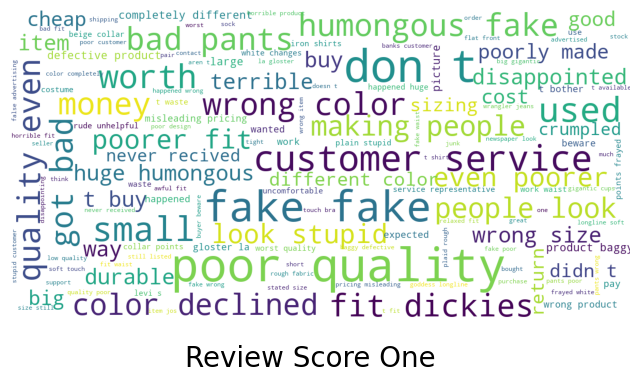

In [58]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

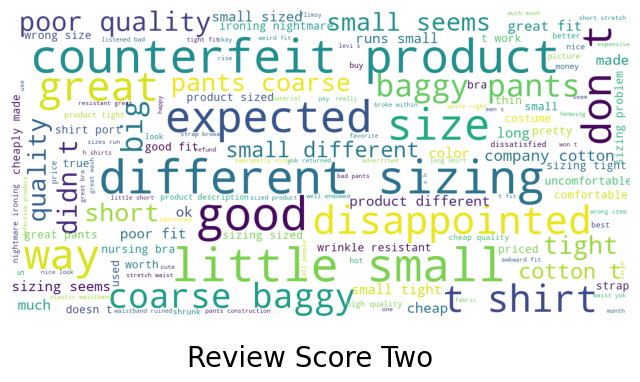

In [59]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

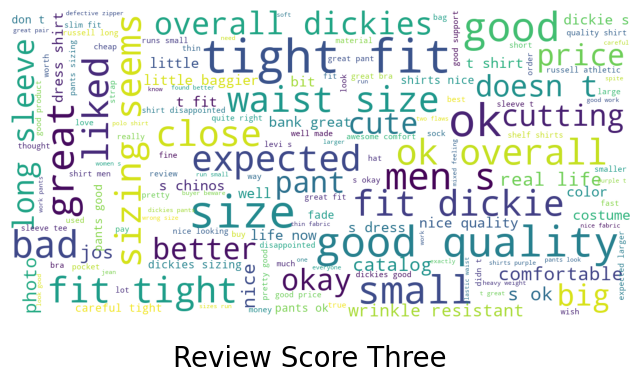

In [60]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score Three")

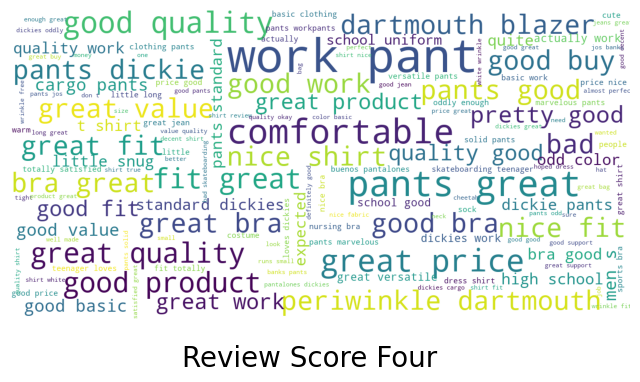

In [61]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Four")

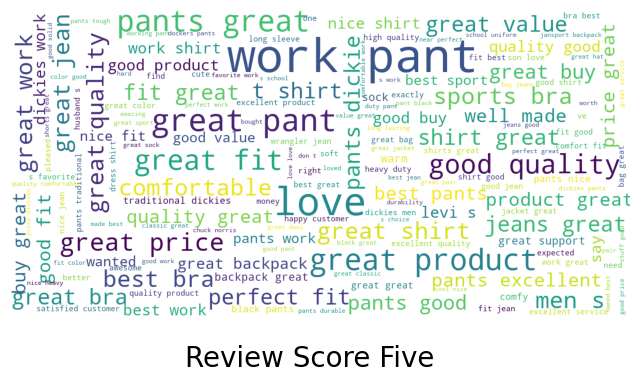

In [63]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")